### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either pure __tensorflow__ or __keras__. Feel free to adapt the seminar code for your needs.


In [2]:
import keras
import keras.models as M
import keras.layers as L

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline

Using TensorFlow backend.


In [3]:
!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz
data = pd.read_csv("./Train_rev1.csv", index_col=None, encoding='utf8')
data.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  29.9M      0  0:00:04  0:00:04 --:--:-- 35.3M
Train_rev1.csv


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [4]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

tokenizer = nltk.tokenize.WordPunctTokenizer()
tokenize = lambda x: ' '.join(tokenizer.tokenize(str(x).lower()))

data[text_columns] = data[text_columns].applymap(tokenize)
data[categorical_columns] = data[categorical_columns].fillna('NaN')
data[target_column] = np.log1p(data['SalaryNormalized']).astype('float32')
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,engineering systems analyst,engineering systems analyst dorking surrey sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,stress engineer glasgow,stress engineer glasgow salary **** to **** we...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,modelling and simulation analyst,mathematical modeller / simulation analyst / o...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986
3,12613049,engineering systems analyst / mathematical mod...,engineering systems analyst / mathematical mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk,10.221977
4,12613647,"pioneer , miser engineering systems analyst","pioneer , miser engineering systems analyst do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671


In [0]:
token_counts = Counter()
for e in data['Title'].append(data['FullDescription']):
    for s in e.split(' '):
        token_counts[s] += 1

UNK, PAD = "UNK", "PAD"
min_count = 10
tokens = [el for el in token_counts.keys() if token_counts[el] >= min_count]
tokens = [UNK, PAD] + sorted(tokens)
token_to_id = {tokens[i]: i for i in range(len(tokens))}

In [6]:
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

In [0]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

In [0]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

def print_metrics(model, data, batch_size=256, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error

In [0]:
def build_model_baseline(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    print(n_tokens)
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    emb = L.Embedding(n_tokens, hid_size)
    
    l_title_emb = emb(l_title)
    l_title_conv = L.Conv1D(filters=hid_size, kernel_size=2, activation='relu')(l_title_emb)
    l_title_out = L.GlobalMaxPool1D()(l_title_conv)
    
    l_descr_emb = emb(l_descr)
    l_descr_conv = L.Conv1D(filters=hid_size, kernel_size=3, activation='relu')(l_descr_emb)
    l_descr_out = L.GlobalMaxPool1D()(l_descr_conv)
    
    l_categ_out = L.Dense(hid_size, activation='relu')(l_categ)

    l_combined = L.Concatenate()([l_title_out, l_descr_out, l_categ_out])
    l_combined_dense = L.Dense(2 * hid_size, activation='relu')(l_combined)
    
    output_layer = L.Dense(1)(l_combined_dense)
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [27]:
batch_size = 256
epochs = 10
steps_per_epoch = (len(data_train) - 1) // batch_size + 1

model_baseline = build_model_baseline()

hist_baseline = model_baseline.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                                    validation_steps=data_val.shape[0] // batch_size)

34158
Epoch 1/10
765/765 [==============================] - 109s 142ms/step - loss: 2.9087 - mean_absolute_error: 0.6329 - val_loss: 0.0912 - val_mean_absolute_error: 0.2256
Epoch 2/10
765/765 [==============================] - 93s 121ms/step - loss: 0.0774 - mean_absolute_error: 0.2063 - val_loss: 0.0726 - val_mean_absolute_error: 0.1992
Epoch 3/10
765/765 [==============================] - 91s 119ms/step - loss: 0.0600 - mean_absolute_error: 0.1804 - val_loss: 0.0637 - val_mean_absolute_error: 0.1862
Epoch 4/10
765/765 [==============================] - 96s 126ms/step - loss: 0.0512 - mean_absolute_error: 0.1663 - val_loss: 0.0597 - val_mean_absolute_error: 0.1786
Epoch 5/10
765/765 [==============================] - 94s 123ms/step - loss: 0.0451 - mean_absolute_error: 0.1563 - val_loss: 0.0603 - val_mean_absolute_error: 0.1805
Epoch 6/10
765/765 [==============================] - 93s 122ms/step - loss: 0.0408 - mean_absolute_error: 0.1488 - val_loss: 0.0573 - val_mean_absolute_error

In [10]:
print_metrics(model_baseline, data_train, name='Train')
print_metrics(model_baseline, data_val, name='Val')

Train results:
Mean square error: 0.02734
Mean absolute error: 0.12481
Val results:
Mean square error: 0.06157
Mean absolute error: 0.18368


(3013.8750245571136, 8991.702272415161)

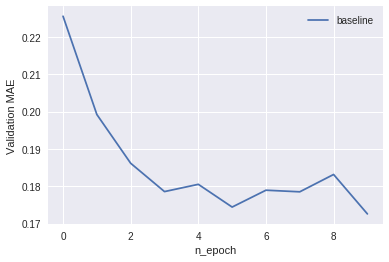

In [29]:
def print_maes(keys=None):
    plt.figure()
    plt.xlabel('n_epoch')
    plt.ylabel('Validation MAE')
    for name in maes if keys is None else keys:
        mae = maes[name]
        xs = range(len(mae))
        plt.plot(xs, mae, label=name)
    plt.legend()

maes = {}
maes['baseline'] = hist_baseline.history['val_mean_absolute_error']
print_maes()

In [12]:
model_baseline2 = build_model_baseline()

hist_baseline_no_dropout = model_baseline2.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0), 
                                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                                    validation_steps=data_val.shape[0] // batch_size)

34158
Epoch 1/10
765/765 [==============================] - 86s 112ms/step - loss: 2.4015 - mean_absolute_error: 0.5842 - val_loss: 0.0918 - val_mean_absolute_error: 0.2268
Epoch 2/10
765/765 [==============================] - 86s 112ms/step - loss: 0.0775 - mean_absolute_error: 0.2067 - val_loss: 0.0745 - val_mean_absolute_error: 0.2022
Epoch 3/10
765/765 [==============================] - 82s 107ms/step - loss: 0.0621 - mean_absolute_error: 0.1840 - val_loss: 0.0697 - val_mean_absolute_error: 0.1946
Epoch 4/10
765/765 [==============================] - 87s 114ms/step - loss: 0.0545 - mean_absolute_error: 0.1720 - val_loss: 0.0670 - val_mean_absolute_error: 0.1907
Epoch 5/10
765/765 [==============================] - 83s 109ms/step - loss: 0.0485 - mean_absolute_error: 0.1621 - val_loss: 0.0671 - val_mean_absolute_error: 0.1913
Epoch 6/10
765/765 [==============================] - 88s 115ms/step - loss: 0.0443 - mean_absolute_error: 0.1548 - val_loss: 0.0637 - val_mean_absolute_error:

Train results:
Mean square error: 0.02495
Mean absolute error: 0.11433
Val results:
Mean square error: 0.06106
Mean absolute error: 0.17997


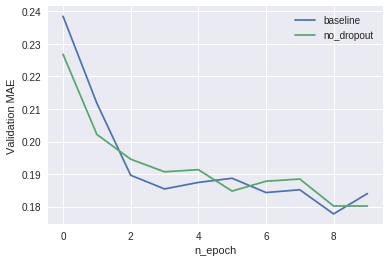

In [13]:
print_metrics(model_baseline2, data_train, name='Train')
print_metrics(model_baseline2, data_val, name='Val')
maes['no_dropout'] = hist_baseline_no_dropout.history['val_mean_absolute_error']
print_maes()

In [14]:
model_baseline3 = build_model_baseline()

hist_baseline_inc_dropout = model_baseline3.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.1), 
                                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                                    validation_steps=data_val.shape[0] // batch_size)

34158
Epoch 1/10
765/765 [==============================] - 90s 117ms/step - loss: 2.8109 - mean_absolute_error: 0.6260 - val_loss: 0.1542 - val_mean_absolute_error: 0.3105
Epoch 2/10
765/765 [==============================] - 95s 124ms/step - loss: 0.0813 - mean_absolute_error: 0.2124 - val_loss: 0.0942 - val_mean_absolute_error: 0.2340
Epoch 3/10
765/765 [==============================] - 89s 116ms/step - loss: 0.0649 - mean_absolute_error: 0.1885 - val_loss: 0.0874 - val_mean_absolute_error: 0.2265
Epoch 4/10
765/765 [==============================] - 89s 116ms/step - loss: 0.0543 - mean_absolute_error: 0.1722 - val_loss: 0.0654 - val_mean_absolute_error: 0.1900
Epoch 5/10
765/765 [==============================] - 88s 115ms/step - loss: 0.0463 - mean_absolute_error: 0.1589 - val_loss: 0.0604 - val_mean_absolute_error: 0.1819
Epoch 6/10
765/765 [==============================] - 88s 115ms/step - loss: 0.0411 - mean_absolute_error: 0.1499 - val_loss: 0.0660 - val_mean_absolute_error:

Train results:
Mean square error: 0.04427
Mean absolute error: 0.17424
Val results:
Mean square error: 0.08014
Mean absolute error: 0.22034


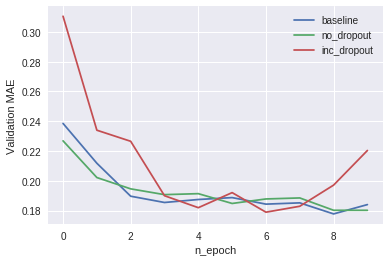

In [15]:
print_metrics(model_baseline3, data_train, name='Train')
print_metrics(model_baseline3, data_val, name='Val')
maes['inc_dropout'] = hist_baseline_inc_dropout.history['val_mean_absolute_error']
print_maes()

In [0]:
def build_model_dropout(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    emb = L.Embedding(n_tokens, hid_size)
    
    l_title_emb = emb(l_title)
    l_title_conv = L.Conv1D(filters=hid_size, kernel_size=2, activation='relu')(l_title_emb)
    l_title_out = L.GlobalMaxPool1D()(l_title_conv)
    
    l_descr_emb = emb(l_descr)
    l_descr_conv = L.Conv1D(filters=hid_size, kernel_size=3, activation='relu')(l_descr_emb)
    l_descr_out = L.GlobalMaxPool1D()(l_descr_conv)
    
    l_categ_out = L.Dense(hid_size, activation='relu')(l_categ)
    
    l_combined = L.Concatenate()([l_title_out, l_descr_out, l_categ_out])
    l_combined_dense = L.Dense(2 * hid_size, activation='relu')(l_combined)
    
    # Adding dropout with p=0.5 after fully connected layer
    l_combined_dropout = L.Dropout(0.5)(l_combined_dense)
    output_layer = L.Dense(1)(l_combined_dropout)
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [17]:
model_dropout = build_model_dropout()

hist_dropout = model_dropout.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                                    validation_steps=data_val.shape[0] // batch_size)

Epoch 1/10
765/765 [==============================] - 95s 125ms/step - loss: 4.4546 - mean_absolute_error: 1.3910 - val_loss: 0.1728 - val_mean_absolute_error: 0.3237
Epoch 2/10
765/765 [==============================] - 93s 122ms/step - loss: 1.8000 - mean_absolute_error: 1.0714 - val_loss: 0.1254 - val_mean_absolute_error: 0.2732
Epoch 3/10
765/765 [==============================] - 90s 118ms/step - loss: 1.7379 - mean_absolute_error: 1.0513 - val_loss: 0.0962 - val_mean_absolute_error: 0.2354
Epoch 4/10
765/765 [==============================] - 94s 123ms/step - loss: 1.6422 - mean_absolute_error: 1.0226 - val_loss: 0.1042 - val_mean_absolute_error: 0.2507
Epoch 5/10
765/765 [==============================] - 90s 118ms/step - loss: 1.5323 - mean_absolute_error: 0.9874 - val_loss: 0.1996 - val_mean_absolute_error: 0.3767
Epoch 6/10
765/765 [==============================] - 90s 117ms/step - loss: 1.3967 - mean_absolute_error: 0.9432 - val_loss: 0.0857 - val_mean_absolute_error: 0.222

Train results:
Mean square error: 0.06305
Mean absolute error: 0.18860
Val results:
Mean square error: 0.07120
Mean absolute error: 0.19976


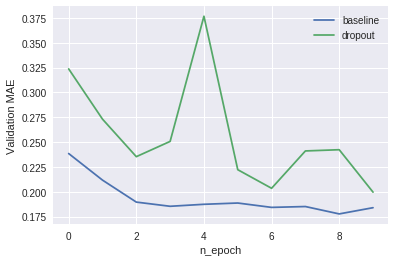

In [18]:
print_metrics(model_dropout, data_train, name='Train')
print_metrics(model_dropout, data_val, name='Val')
maes['dropout'] = hist_dropout.history['val_mean_absolute_error']
print_maes(['baseline', 'dropout'])

In [0]:
def build_model_dropout2(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    emb = L.Embedding(n_tokens, hid_size)
    
    l_title_emb = emb(l_title)
    l_title_conv = L.Conv1D(filters=hid_size, kernel_size=2, activation='relu')(l_title_emb)
    # Adding dropout with p=0.1 after convolution layers
    l_title_dropout = L.Dropout(0.1)(l_title_conv)
    l_title_out = L.GlobalMaxPool1D()(l_title_dropout)
    
    l_descr_emb = emb(l_descr)
    l_descr_conv = L.Conv1D(filters=hid_size, kernel_size=3, activation='relu')(l_descr_emb)
    # Adding dropout with p=0.1 after convolution layers
    l_descr_dropout = L.Dropout(0.1)(l_descr_conv)
    l_descr_out = L.GlobalMaxPool1D()(l_descr_dropout)
    
    l_categ_out = L.Dense(hid_size, activation='relu')(l_categ)
    
    l_combined = L.Concatenate()([l_title_out, l_descr_out, l_categ_out])
    l_combined_dense = L.Dense(2 * hid_size, activation='relu')(l_combined)
    
    # Adding dropout with p=0.5 after fully connected layer
    l_combined_dropout = L.Dropout(0.4)(l_combined_dense)
    output_layer = L.Dense(1)(l_combined_dropout)
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [20]:
model_dropout2 = build_model_dropout2()

hist_dropout2 = model_dropout2.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                                    validation_steps=data_val.shape[0] // batch_size)

Epoch 1/10
765/765 [==============================] - 99s 129ms/step - loss: 3.7774 - mean_absolute_error: 1.1918 - val_loss: 0.9407 - val_mean_absolute_error: 0.9100
Epoch 2/10
765/765 [==============================] - 95s 124ms/step - loss: 1.1605 - mean_absolute_error: 0.8584 - val_loss: 0.9367 - val_mean_absolute_error: 0.9180
Epoch 3/10
765/765 [==============================] - 95s 124ms/step - loss: 1.1320 - mean_absolute_error: 0.8483 - val_loss: 0.7782 - val_mean_absolute_error: 0.8349
Epoch 4/10
765/765 [==============================] - 98s 128ms/step - loss: 1.0790 - mean_absolute_error: 0.8279 - val_loss: 1.1278 - val_mean_absolute_error: 1.0248
Epoch 5/10
765/765 [==============================] - 97s 127ms/step - loss: 1.0309 - mean_absolute_error: 0.8090 - val_loss: 0.7967 - val_mean_absolute_error: 0.8508
Epoch 6/10
765/765 [==============================] - 96s 125ms/step - loss: 0.9816 - mean_absolute_error: 0.7894 - val_loss: 1.0988 - val_mean_absolute_error: 1.013

Train results:
Mean square error: 0.52289
Mean absolute error: 0.68417
Val results:
Mean square error: 0.53647
Mean absolute error: 0.68874


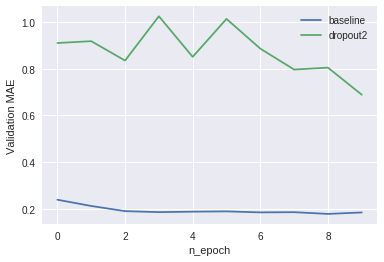

In [21]:
print_metrics(model_dropout2, data_train, name='Train')
print_metrics(model_dropout2, data_val, name='Val')
maes['dropout2'] = hist_dropout2.history['val_mean_absolute_error']
print_maes(['baseline', 'dropout', 'dropout2'])

In [0]:
def build_model_batchnorm(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    emb = L.Embedding(n_tokens, hid_size)
    
    l_title_emb = emb(l_title)
    l_title_conv = L.Conv1D(filters=hid_size, kernel_size=2)(l_title_emb)
    # Adding batch normalization before activation
    l_title_batchnorm = L.BatchNormalization()(l_title_conv)
    l_title_activation = L.Activation('relu')(l_title_batchnorm)
    l_title_out = L.GlobalMaxPool1D()(l_title_activation)
    
    l_descr_emb = emb(l_descr)
    l_descr_conv = L.Conv1D(filters=hid_size, kernel_size=3)(l_descr_emb)
    # Adding batch normalization before activation
    l_descr_batchnorm = L.BatchNormalization()(l_descr_conv)
    l_descr_activation = L.Activation('relu')(l_descr_batchnorm)
    l_descr_out = L.GlobalMaxPool1D()(l_descr_activation)
    
    l_categ_out = L.Dense(hid_size, activation='relu')(l_categ)

    l_combined = L.Concatenate()([l_title_out, l_descr_out, l_categ_out])
    l_combined_dense = L.Dense(2 * hid_size, activation='relu')(l_combined)
    
    output_layer = L.Dense(1)(l_combined_dense)
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [23]:
model_batchnorm = build_model_batchnorm()

hist_batchnorm = model_batchnorm.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                                    validation_steps=data_val.shape[0] // batch_size)

Epoch 1/10
765/765 [==============================] - 101s 131ms/step - loss: 0.7671 - mean_absolute_error: 0.4845 - val_loss: 0.1380 - val_mean_absolute_error: 0.2895
Epoch 2/10
765/765 [==============================] - 102s 134ms/step - loss: 0.0939 - mean_absolute_error: 0.2313 - val_loss: 0.0929 - val_mean_absolute_error: 0.2280
Epoch 3/10
765/765 [==============================] - 101s 133ms/step - loss: 0.0674 - mean_absolute_error: 0.1959 - val_loss: 0.0764 - val_mean_absolute_error: 0.2060
Epoch 4/10
765/765 [==============================] - 101s 132ms/step - loss: 0.0589 - mean_absolute_error: 0.1832 - val_loss: 0.0746 - val_mean_absolute_error: 0.2017
Epoch 5/10
765/765 [==============================] - 104s 136ms/step - loss: 0.0543 - mean_absolute_error: 0.1769 - val_loss: 0.0847 - val_mean_absolute_error: 0.2231
Epoch 6/10
765/765 [==============================] - 102s 133ms/step - loss: 0.0567 - mean_absolute_error: 0.1824 - val_loss: 0.1181 - val_mean_absolute_error:

Train results:
Mean square error: 0.03213
Mean absolute error: 0.13606
Val results:
Mean square error: 0.06658
Mean absolute error: 0.19084


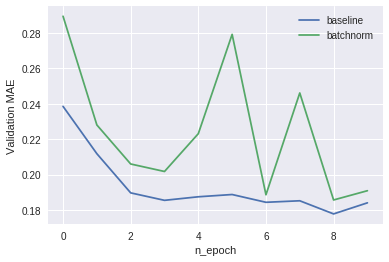

In [24]:
print_metrics(model_batchnorm, data_train, name='Train')
print_metrics(model_batchnorm, data_val, name='Val')
maes['batchnorm'] = hist_batchnorm.history['val_mean_absolute_error']
print_maes(['baseline', 'batchnorm'])

In [0]:
def build_model_batchnorm2(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    emb = L.Embedding(n_tokens, hid_size)
    
    l_title_emb = emb(l_title)
    l_title_conv = L.Conv1D(filters=hid_size, kernel_size=2, activation='relu')(l_title_emb)
    # Adding batch normalization after activation
    l_title_batchnorm = L.BatchNormalization()(l_title_conv)
    l_title_out = L.GlobalMaxPool1D()(l_title_batchnorm)
    
    l_descr_emb = emb(l_descr)
    l_descr_conv = L.Conv1D(filters=hid_size, kernel_size=3, activation='relu')(l_descr_emb)
    # Adding batch normalization after activation
    l_descr_batchnorm = L.BatchNormalization()(l_descr_conv)
    l_descr_out = L.GlobalMaxPool1D()(l_descr_batchnorm)
    
    l_categ_out = L.Dense(hid_size, activation='relu')(l_categ)

    l_combined = L.Concatenate()([l_title_out, l_descr_out, l_categ_out])
    l_combined_dense = L.Dense(2 * hid_size, activation='relu')(l_combined)
    
    output_layer = L.Dense(1)(l_combined_dense)
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [26]:
model_batchnorm2 = build_model_batchnorm2()

hist_batchnorm2 = model_batchnorm2.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                                    validation_steps=data_val.shape[0] // batch_size)

Epoch 1/10
765/765 [==============================] - 105s 137ms/step - loss: 0.7957 - mean_absolute_error: 0.4406 - val_loss: 0.1425 - val_mean_absolute_error: 0.2952
Epoch 2/10
765/765 [==============================] - 98s 128ms/step - loss: 0.0838 - mean_absolute_error: 0.2182 - val_loss: 0.1043 - val_mean_absolute_error: 0.2497
Epoch 3/10
765/765 [==============================] - 96s 126ms/step - loss: 0.0634 - mean_absolute_error: 0.1902 - val_loss: 0.0771 - val_mean_absolute_error: 0.2077
Epoch 4/10
765/765 [==============================] - 102s 133ms/step - loss: 0.0564 - mean_absolute_error: 0.1799 - val_loss: 0.0927 - val_mean_absolute_error: 0.2362
Epoch 5/10
765/765 [==============================] - 97s 127ms/step - loss: 0.0532 - mean_absolute_error: 0.1759 - val_loss: 0.0756 - val_mean_absolute_error: 0.2073
Epoch 6/10
765/765 [==============================] - 97s 127ms/step - loss: 0.0511 - mean_absolute_error: 0.1731 - val_loss: 0.1500 - val_mean_absolute_error: 0.3

Train results:
Mean square error: 0.09438
Mean absolute error: 0.26792
Val results:
Mean square error: 0.12709
Mean absolute error: 0.29417


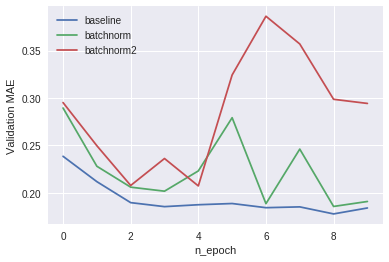

In [27]:
print_metrics(model_batchnorm2, data_train, name='Train')
print_metrics(model_batchnorm2, data_val, name='Val')
maes['batchnorm2'] = hist_batchnorm2.history['val_mean_absolute_error']
print_maes(['baseline', 'batchnorm', 'batchnorm2'])

In [0]:
def build_model_avg_pooling(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    emb = L.Embedding(n_tokens, hid_size)
    
    l_title_emb = emb(l_title)
    l_title_conv = L.Conv1D(filters=hid_size, kernel_size=2, activation='relu')(l_title_emb)
    l_title_out = L.GlobalAvgPool1D()(l_title_conv)
    
    l_descr_emb = emb(l_descr)
    l_descr_conv = L.Conv1D(filters=hid_size, kernel_size=3, activation='relu')(l_descr_emb)
    l_descr_out = L.GlobalAvgPool1D()(l_descr_conv)
    
    l_categ_out = L.Dense(hid_size, activation='relu')(l_categ)

    l_combined = L.Concatenate()([l_title_out, l_descr_out, l_categ_out])
    l_combined_dense = L.Dense(2 * hid_size, activation='relu')(l_combined)
    
    output_layer = L.Dense(1)(l_combined_dense)
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [29]:
model_avg_pooling = build_model_avg_pooling()

hist_avg_pooling = model_avg_pooling.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                                    validation_steps=data_val.shape[0] // batch_size)

Epoch 1/10
765/765 [==============================] - 91s 119ms/step - loss: 3.1427 - mean_absolute_error: 0.6367 - val_loss: 0.0866 - val_mean_absolute_error: 0.2227
Epoch 2/10
765/765 [==============================] - 92s 121ms/step - loss: 0.0783 - mean_absolute_error: 0.2095 - val_loss: 0.0758 - val_mean_absolute_error: 0.2061
Epoch 3/10
765/765 [==============================] - 87s 114ms/step - loss: 0.0691 - mean_absolute_error: 0.1959 - val_loss: 0.0718 - val_mean_absolute_error: 0.2004
Epoch 4/10
765/765 [==============================] - 86s 113ms/step - loss: 0.0640 - mean_absolute_error: 0.1886 - val_loss: 0.0707 - val_mean_absolute_error: 0.1996
Epoch 5/10
765/765 [==============================] - 84s 110ms/step - loss: 0.0588 - mean_absolute_error: 0.1806 - val_loss: 0.0689 - val_mean_absolute_error: 0.1955
Epoch 6/10
765/765 [==============================] - 88s 115ms/step - loss: 0.0556 - mean_absolute_error: 0.1758 - val_loss: 0.0665 - val_mean_absolute_error: 0.190

Train results:
Mean square error: 0.03846
Mean absolute error: 0.14389
Val results:
Mean square error: 0.06329
Mean absolute error: 0.18513


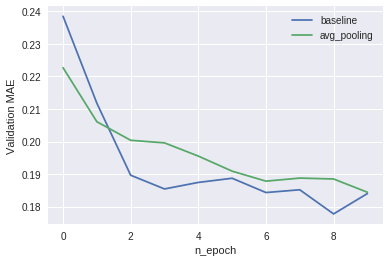

In [30]:
print_metrics(model_avg_pooling, data_train, name='Train')
print_metrics(model_avg_pooling, data_val, name='Val')
maes['avg_pooling'] = hist_avg_pooling.history['val_mean_absolute_error']
print_maes(['baseline', 'avg_pooling'])

In [0]:
def build_model_more_layers(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    emb = L.Embedding(n_tokens, hid_size)
    # stack_more_layers.jpg
    l_title_emb = emb(l_title)
    l_title_conv = L.Conv1D(filters=hid_size, kernel_size=2, activation='relu')(l_title_emb)
    l_title_out = L.GlobalAvgPool1D()(l_title_conv)
    
    l_descr_emb = emb(l_descr)
    l_descr_conv = L.Conv1D(filters=hid_size, kernel_size=3, activation='relu')(l_descr_emb)
    l_descr_out = L.GlobalAvgPool1D()(l_descr_conv)
    
    l_categ_out = L.Dense(hid_size, activation='relu')(l_categ)

    l_combined = L.Concatenate()([l_title_out, l_descr_out, l_categ_out])
    l_combined_dense = L.Dense(2 * hid_size, activation='relu')(l_combined)
    l_out = L.Dense(hid_size, activation='relu')(l_combined_dense)
    l_out2 = L.Dense(int(hid_size/2), activation='relu')(l_out)
    
    output_layer = L.Dense(1)(l_out2)
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [32]:
model_more_layers = build_model_more_layers()

hist_more_layers = model_more_layers.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                                    validation_steps=data_val.shape[0] // batch_size)

Epoch 1/10
765/765 [==============================] - 92s 120ms/step - loss: 3.1861 - mean_absolute_error: 0.6352 - val_loss: 0.0816 - val_mean_absolute_error: 0.2143
Epoch 2/10
765/765 [==============================] - 93s 122ms/step - loss: 0.0748 - mean_absolute_error: 0.2044 - val_loss: 0.0718 - val_mean_absolute_error: 0.2001
Epoch 3/10
765/765 [==============================] - 89s 117ms/step - loss: 0.0653 - mean_absolute_error: 0.1905 - val_loss: 0.0685 - val_mean_absolute_error: 0.1948
Epoch 4/10
765/765 [==============================] - 87s 114ms/step - loss: 0.0602 - mean_absolute_error: 0.1826 - val_loss: 0.0677 - val_mean_absolute_error: 0.1941
Epoch 5/10
765/765 [==============================] - 94s 122ms/step - loss: 0.0566 - mean_absolute_error: 0.1771 - val_loss: 0.0692 - val_mean_absolute_error: 0.1971
Epoch 6/10
765/765 [==============================] - 88s 115ms/step - loss: 0.0538 - mean_absolute_error: 0.1730 - val_loss: 0.0645 - val_mean_absolute_error: 0.188

Train results:
Mean square error: 0.04250
Mean absolute error: 0.15526
Val results:
Mean square error: 0.06928
Mean absolute error: 0.19669


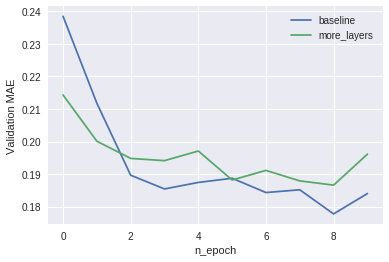

In [33]:
print_metrics(model_more_layers, data_train, name='Train')
print_metrics(model_more_layers, data_val, name='Val')
maes['more_layers'] = hist_more_layers.history['val_mean_absolute_error']
print_maes(['baseline', 'more_layers'])

In [34]:
model_more_layers2 = build_model_baseline(hid_size=128)

hist_more_layers2 = model_more_layers2.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                                    validation_steps=data_val.shape[0] // batch_size)

34158
Epoch 1/10
765/765 [==============================] - 175s 228ms/step - loss: 1.6690 - mean_absolute_error: 0.4868 - val_loss: 0.0892 - val_mean_absolute_error: 0.2238
Epoch 2/10
765/765 [==============================] - 114s 149ms/step - loss: 0.0704 - mean_absolute_error: 0.1967 - val_loss: 0.0692 - val_mean_absolute_error: 0.1943
Epoch 3/10
765/765 [==============================] - 108s 142ms/step - loss: 0.0538 - mean_absolute_error: 0.1713 - val_loss: 0.0743 - val_mean_absolute_error: 0.2056
Epoch 4/10
765/765 [==============================] - 108s 141ms/step - loss: 0.0460 - mean_absolute_error: 0.1585 - val_loss: 0.0585 - val_mean_absolute_error: 0.1771
Epoch 5/10
765/765 [==============================] - 107s 139ms/step - loss: 0.0414 - mean_absolute_error: 0.1509 - val_loss: 0.0596 - val_mean_absolute_error: 0.1797
Epoch 6/10
765/765 [==============================] - 108s 142ms/step - loss: 0.0370 - mean_absolute_error: 0.1426 - val_loss: 0.0563 - val_mean_absolute_

Train results:
Mean square error: 0.03191
Mean absolute error: 0.14309
Val results:
Mean square error: 0.06814
Mean absolute error: 0.19799


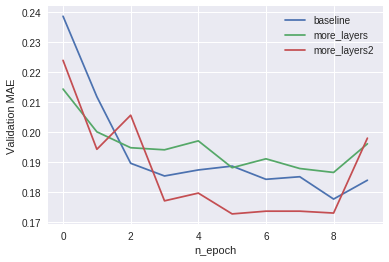

In [35]:
print_metrics(model_more_layers2, data_train, name='Train')
print_metrics(model_more_layers2, data_val, name='Val')
maes['more_layers2'] = hist_more_layers2.history['val_mean_absolute_error']
print_maes(['baseline', 'more_layers', 'more_layers2'])

In [10]:
!pip install gensim

In [0]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

In [12]:
indices = {}
mat = np.zeros((len(tokens), embeddings.wv.vectors.shape[1]))
for e in embeddings.vocab:
    if e in token_to_id:
        mat[token_to_id[e], : ] = embeddings[e]

print(len(tokens))
print(mat.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


34158
(34158, 300)


In [22]:
shuffle=True
indices = np.arange(len(data_train))
if shuffle:
    indices = np.random.permutation(indices)

start = 0
batch = make_batch(data_train.iloc[indices[start : start + batch_size]])
target = batch.pop(target_column)

batch
batch['FullDescription'].max(), batch['Title'].max()

(34149, 34100)

In [0]:
from keras.initializers import Constant

def build_model_embedding(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    print(n_tokens)
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    emb = L.Embedding(input_dim=n_tokens, weights=[mat], output_dim=300)

    l_title_emb = emb(l_title)
    l_title_conv = L.Conv1D(filters=hid_size, kernel_size=2, activation='relu')(l_title_emb)
    l_title_out = L.GlobalMaxPool1D()(l_title_conv)
    
    l_descr_emb = emb(l_descr)
    l_descr_conv = L.Conv1D(filters=hid_size, kernel_size=3, activation='relu')(l_descr_emb)
    l_descr_out = L.GlobalMaxPool1D()(l_descr_conv)
    
    l_categ_out = L.Dense(hid_size, activation='relu')(l_categ)

    l_combined = L.Concatenate()([l_title_out, l_descr_out, l_categ_out])
    l_combined_dense = L.Dense(2 * hid_size, activation='relu')(l_combined)
    
    output_layer = L.Dense(1)(l_combined_dense)
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [25]:
batch_size = 256
epochs = 10
steps_per_epoch = (len(data_train) - 1) // batch_size + 1

model_embedding = build_model_embedding()

hist_embedding = model_embedding.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0), 
                                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                                    validation_steps=data_val.shape[0] // batch_size)

34158
Epoch 1/10
765/765 [==============================] - 221s 288ms/step - loss: 1.2916 - mean_absolute_error: 0.4493 - val_loss: 0.0828 - val_mean_absolute_error: 0.2140
Epoch 2/10
765/765 [==============================] - 137s 179ms/step - loss: 0.0704 - mean_absolute_error: 0.1957 - val_loss: 0.0696 - val_mean_absolute_error: 0.1948
Epoch 3/10
765/765 [==============================] - 132s 173ms/step - loss: 0.0547 - mean_absolute_error: 0.1719 - val_loss: 0.0617 - val_mean_absolute_error: 0.1818
Epoch 4/10
765/765 [==============================] - 133s 174ms/step - loss: 0.0445 - mean_absolute_error: 0.1548 - val_loss: 0.0590 - val_mean_absolute_error: 0.1783
Epoch 5/10
765/765 [==============================] - 132s 173ms/step - loss: 0.0375 - mean_absolute_error: 0.1425 - val_loss: 0.0583 - val_mean_absolute_error: 0.1767
Epoch 6/10
765/765 [==============================] - 131s 171ms/step - loss: 0.0325 - mean_absolute_error: 0.1335 - val_loss: 0.0557 - val_mean_absolute_

In [28]:
print_metrics(model_embedding, data_train, name='Train')
print_metrics(model_embedding, data_val, name='Val')

Train results:
Mean square error: 0.01806
Mean absolute error: 0.10258
Val results:
Mean square error: 0.05929
Mean absolute error: 0.17789


NameError: ignored

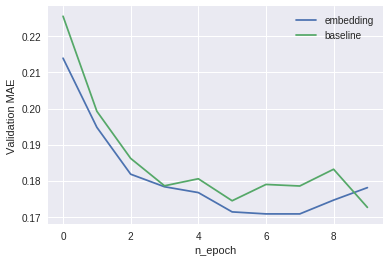

In [30]:
maes['embedding'] = hist_embedding.history['val_mean_absolute_error']
print_maes(['embedding', 'baseline'])

### A short report

Please tell us what you did and how did it work.

* Попробовал добавить в baseline-решение слой dropout. Сначала добавил `L.Dropout(p=0.5)` после полносвязного слоя (на графике подписан `dropout`), затем попробовал добавить `L.Dropout(p=0.1)` после свертки (на графике `dropout2`), [здесь](https://stats.stackexchange.com/a/317313) писали, что в некоторых случаях может помочь. По графику видно, что оба раза дропаут ухудшил результат, притом дропаут после сверточного слоя очень сильно ухудшил качество.
* Попробовал менять параметр `word_dropout` при обучении, попробовал совсем убрать дропаут слов (`word_dropout=0`), качество не изменилось по сравнению с бейзлайном, попробовал увеличить дропаут (`word_dropout=0.1`), качество сильно упало.
* Попробовал добавить в baseline-решение слой BatchNormalization после сверточных слоев перед функцией активации. По графику (`batchnorm`) видно, что качество не улучшилось по отношению к бейзлайну, но и не сильно ухудшилось. Мнения по поводу того, стоит ли вставлять слой BatchNormalization до слоя активации или после [расходятся](https://stackoverflow.com/a/45624249), попробовал также вставить слой BatchNormalization после функции активации, качество также не улучшилось (на графике `batchnorm2`).
* Попробовал заменить L.GlobalMaxPool1D на L.GlobalAvgPool1D, качество не улучшилось по сравнению с бейзлайном (на графике `avg_pooling`).
* Попробовал добаить больше слоев на выходе, качество не улучшилось (`more_layers` на графике).
* Попробовал увеличить размер слоев (`hid_size`) с 64 до 128, заметил значительный прирост качества для первых 8 эпох.
* Попробовал использовать предобученные embedding'и, на графике видно, что качество улучшилось по сравнению с бейзлайном для первых 9 эпох (на графике `embedding`).

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time - our `L.GlobalMaxPool1D`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not want to use __`.get_keras_embedding()`__ method for word2vec
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback](https://keras.io/callbacks/#earlystopping).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!